# softmax回归
通过逻辑回归我们已经了解了模型的基本分类，逻辑回归是处理二分类问题，但是现实中有许多场景是需要多分类的，所以需要一种模型能够处理多分类，本文介绍的softmax回归模型就是能够处理多分类的，它的预测结果是一个向量，下面我们详细介绍模型的基本构成。

## softmax回归模型
+ 数据：根据问题来的，比如预测图片里面是汽车、猫、狗等，我们会收集很多图片，而彩色图片一般有3个通道，每个通道均是28*28的矩阵，每个像素点取值是0-256之间，从图片中我们可以提炼很多变量，当然直接将每个像素点也可以当成一个变量，还会收集图片真正包含的图片是什么【答案或者目标】，这个就是训练样本
+ 模型：假设softmax回归模型的预测结果有3类
  - O1 = b11 + a11\*x1 + a12\*x2 + a1n\*xm
  - O2 = b21 + a21\*x1 + a22\*x2 + a2n\*xm
  - O3 = b31 + a31\*x1 + a32\*x2 + a3n\*xm 

  那么预测结果向量为：\[y_hat1=exp(O1)/sum(exp(Oi)), y_hat2=exp(O2)/sum(exp(Oi)), y_hat3=exp(O3)/sum(exp(Oi))\]
+ 参数：b11 a11 a12 a1m 就是参数
+ 损失函数：z = sum(-(y1\*log(y_hat1) + y2\*log(y_hat2) + y3\*log(y_hat3)))/n，n 是样本数量
+ 优化方法：梯度下降等，得益于 PyTorch 自动求梯度，我们不再需要显示求出损失函数的导数

可以看到，逻辑回归的模型一部分和线性回归很相似，这也是它名字中包含回归的原因。

本篇开始，因为我们已经掌握了模型基本构造原理，后续模型均是通过 PyTorch Lightning 高级 api 直接实现， https://github.com/PyTorchLightning/pytorch-lightning


## 1. 训练样本准备
下面先了解一下后面我们经常需要用到的数据集，Fashion-MNIST，图像分类数据集中最常用的是手写数字识别数据集MNIST，但大部分模型在MNIST上的分类精度都超过了95%，也就是说MNIST数据集可以说是深度学习中的 HelloWorld，被玩坏了，那我们就玩点图像内容更加复杂的数据集 Fashion-MNIST（这个数据集也比较小，只有几十M，没有GPU的电脑也能吃得消）。    
本节我们将使用 torchvision 包，它是服务于 PyTorch 深度学习框架的，主要用来构建计算机视觉模型。torchvision 主要由以下几部分构成：

+ torchvision.datasets: 一些加载数据的函数及常用的数据集接口
+ torchvision.models: 包含常用的模型结构（含预训练模型），例如AlexNet、VGG、ResNet等
+ torchvision.transforms: 常用的图片变换，例如裁剪、旋转等
+ torchvision.utils: 其他的一些有用的方法

### 1.1 下载数据集

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
mnist_train = torchvision.datasets.FashionMNIST('../../datas', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST('../../datas', train=False, download=True, transform=transforms.ToTensor())

In [18]:
# 打印数据集的类型，以及训练样本和测试样本的数量
print(type(mnist_train))
print('train sample len = {}'.format(len(mnist_train)))
print('test sample len = {}'.format(len(mnist_test)))
print('one picture shape = {}'.format(mnist_train.train_data[0].shape))
feature, label = mnist_train[0]
print(feature.shape, label)

<class 'torchvision.datasets.mnist.FashionMNIST'>
train sample len = 60000
test sample len = 10000
one picture shape = torch.Size([28, 28])
torch.Size([1, 28, 28]) 9


### 1.2 查看图片
可以通过 matplotlib imshow 函数来绘制前10张图片

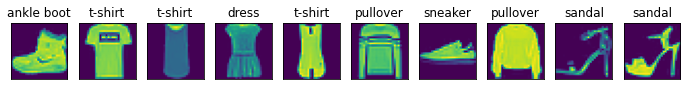

In [21]:
import matplotlib.pyplot as plt
# 获取每一个图片对应类别的英文解释
def get_fashion_mnist_label_name(label_id):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return text_labels[label_id]

def show_fasion_mnist_head(head_num):
    _, figs = plt.subplots(1, head_num, figsize=(12, 12))
    for i in range(0, head_num):
        imgs, label_id = mnist_train[i]
        f = figs[i]
        f.imshow(imgs.view(28, 28))
        f.set_title(get_fashion_mnist_label_name(label_id))
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

show_fasion_mnist_head(10)

## 2. softmax模型实现

In [39]:
# import nessasary lib
import os
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import pytorch_lightning as pl
import numpy as np

In [85]:
class SoftMaxModel(pl.LightningModule):

    def __init__(self):
        super(SoftMaxModel, self).__init__()
        # 定义模型结构
        self.l1 = torch.nn.Linear(28*28, 10)

    def forward(self, x):
        # 必须：定义模型
        return torch.softmax(self.l1(x.view(x.size(0), -1)), dim=0)

    def training_step(self, batch, batch_nb):
        # 必须提供：定于训练过程
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        # 可选提供：定义测试过程
        x, y = batch
        y_hat = self(x)
        return {'test_loss': F.cross_entropy(y_hat, y)}

    def test_epoch_end(self, outputs):
        # 可选提供：定义测试过程
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}
        return {'test_loss': avg_loss, 'log': logs, 'progress_bar': logs}

    def configure_optimizers(self):
        # 必须提供：定义优化器
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.SGD(self.parameters(), lr=0.1)

    def train_dataloader(self):
        # 必须提供：提供训练数据集
        return DataLoader(mnist_train, batch_size=256, shuffle=True, num_workers=4)

    def test_dataloader(self):
        # 可选提供：提供测试数据集
        return DataLoader(mnist_test, batch_size=256, shuffle=False, num_workers=1)

In [86]:
softmax_model = SoftMaxModel()

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(max_epochs=5)
trainer.fit(softmax_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 7 K   
Epoch 5: 100%|██████████| 235/235 [00:02<00:00, 106.68it/s, loss=2.289, v_num=19]


1

In [73]:
trainer.test()
print(softmax_model)

Testing:  94%|█████████▎| 147/157 [00:00<00:00, 174.90it/s]--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(2.1877)}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 157/157 [00:00<00:00, 179.14it/s]
SoftMaxModel(
  (l1): Linear(in_features=784, out_features=10, bias=True)
)


## 3. 直观查看预测结果

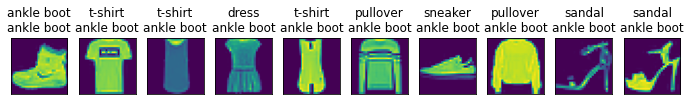

In [74]:
import matplotlib.pyplot as plt
# 获取每一个图片对应类别的英文解释
def get_fashion_mnist_label_name(label_id):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return text_labels[label_id]

def show_fasion_mnist_head(head_num, mnist):
    _, figs = plt.subplots(1, head_num, figsize=(12, 12))
    for i in range(0, head_num):
        imgs, t_label_id = mnist[i]
        p_label_id = torch.argmax(softmax_model(imgs))
        f = figs[i]
        f.imshow(imgs.view(28, 28))
        f.set_title(get_fashion_mnist_label_name(t_label_id) + '\n' + get_fashion_mnist_label_name(p_label_id))
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

show_fasion_mnist_head(10, mnist_train)